# Read combined refinement results for Gd$_2$Hf$_2$O$_7$ D20 (7 temperatures)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
import os
import numpy as np
#from latexify import latexify
%matplotlib ipympl
#%matplotlib inline
from latexify import latexify

In [2]:
# X-ray polarization factor for monochromators
a = 5.4309 # Si lattice parameter
d = a/np.sqrt(3) # d-spacing of [111]
lam = 0.35424 # wavelength
theta=np.arcsin(lam/(2*d))
print(2*theta/np.pi*180)
print(np.cos(2*theta)**2) # cos(theta)^2

a =  6.708 # Graphite lattice parameter
d = a/2 # d-spacing of [002]
lam = np.array([1.54056,1.54439]) # wavelength
theta=np.arcsin(lam/(2*d))
print(np.cos(2*theta)**2) # cos(theta)^2

6.476498785146326
0.9872771374306586
[0.80015256 0.79921331]


In [3]:
17/417

0.0407673860911271

## Define functions

### Read sum file

In [4]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def read_sum_for_227(file, nb_of_phases=7):
    flags = ['ATOM PARAMETERS', 
         'Anisotropic Betas',
         'Cell parameters',
         'Eta(p-v) or m(p-vii)',
         'Halfwidth parameters',
         'Asymmetry parameters',
         'Rwp',
         'Zero-point',
         'Cos(2theta)-shift',
         'Sin(2theta)-shift']
    start_after_flag = [3, 5,  1, 0, 0, 0, 0, 0, 0, 0] # start from
    nb_lines_to_read = [7, 14, 3, 1, 3, 4, 1, 1, 1, 1] # read nb lines
    
    flags_errs = flags + [key+'_err'for key in flags]
    data_dict = {key: [] for key in flags_errs}
    data_dict['Xo48f'] = []
    data_dict['Xo48f_err'] = []
    #print(data_dict.keys())
    
    f=open(file, 'r').readlines()
    
    check_flags = True
    count = 0
    
    for line in f:
        if check_flags:
            for i, flag in enumerate(flags):
                if flag in line:
                    sk = start_after_flag[i]
                    rd = nb_lines_to_read[i]
                    count = 1
                    if not (sk==0 and rd==1): #sk=0, rd=1, only tack the current, and start check flag again 
                        check_flags = False
                    
                    # for these Flags, also take the current line
                    if flag in ['Eta(p-v) or m(p-vii)', 'Halfwidth parameters', 'Asymmetry parameters','Zero-point','Cos(2theta)-shift','Sin(2theta)-shift']:
                        line_s = line.rstrip('\n').split()
                        line_s = [ x for x in line_s if is_number(x) ]
                        #print(line_s)
                        data_dict[flag].append(line_s[0])
                        data_dict[flag+'_err'].append(line_s[1])
                        
                    if flag == 'Rwp':
                        line_s = line.rstrip('\n').split()
                        line_s = [ x for x in line_s if is_number(x) ]
                        #print(line_s)
                        data_dict[flag].append(line_s)
                        
                    break
        else:
            if (count >= sk) and (count <= sk+rd):
                line_s = line.rstrip('\n').split()

                if flag == 'ATOM PARAMETERS':
                    #print(line_s)
                    data_dict[flag].append(line_s[9][:-1])
                    data_dict[flag+'_err'].append(line_s[10][:-1])
                    if count == 7:
                        data_dict['Xo48f'].append(line_s[1][:-1])
                        data_dict['Xo48f'+'_err'].append(line_s[2][:-1])

                if flag == 'Anisotropic Betas':
                    #print(line_s)
                    if len(data_dict[flag])==len(data_dict[flag+'_err']):
                        data_dict[flag].append(line_s[1:])
                    else:
                        data_dict[flag+'_err'].append(line_s)

                if flag in ['Cell parameters', 'Halfwidth parameters', 'Asymmetry parameters']:
                    line_s = [ x for x in line_s if is_number(x) ]
                    #print(line_s)
                    data_dict[flag].append(line_s[0])
                    data_dict[flag+'_err'].append(line_s[1]) 

                count += 1
                if count >= sk+rd:
                    check_flags = True
            else:
                count += 1  
    # per row per phase
    for flag in flags+['Xo48f']:
        data_dict[flag] = np.array(data_dict[flag],dtype='float').reshape(7,-1)     
        data_dict[flag+'_err'] = np.array(data_dict[flag+'_err'],dtype='float').reshape(7,-1)  
    data_dict['Rwp'] = data_dict['Rwp'][:,:8] # take one pair of R: "not corrected bkg" and conventional
    return data_dict


### Read out file 1

In [5]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def read_out_for_227(file, nb_of_phases=7):
    flags = ['occ.',
        'U-Eigen Value',
        'Uequiv',
        'Bequiv',
        'R.M.S.',
        'Cell parameters', 
        'Halfwidth parameters', 
        'Asymmetry parameters',
        'Rwp',
        'Zero-point',
        'Cos(2theta)-shift',
        'Sin(2theta)-shift']
    start_after_flag = [2, 1, 0, 0, 1, 1,1,1,0,0,0,0] # start from
    nb_lines_to_read = [7, 3, 1, 1, 3, 3,3,4,1,1,1,1] # read nb lines
    
    flags_errs = flags + [key+'_err'for key in flags]
    data_dict = {key: [] for key in flags_errs}
    data_dict['Xo48f'] = []
    data_dict['Xo48f_err'] = []
    
    f=open(file, 'r').readlines()
    
    check_flags = True
    count = 0
    
    start = False
    for line in f:
        
        if ~start:
            if 'Convergence reached at this CYCLE' in line:
                start = True
                
        if start:        
            if check_flags:
                for i, flag in enumerate(flags):
                    if flag in line:
                        sk = start_after_flag[i]
                        rd = nb_lines_to_read[i]
                        count = 1
                        if not (sk==0 and rd==1): #sk=0, rd=1, only tack the current, and start check flag again 
                            check_flags = False

                        # for these Flags, also take the current line
                        if flag in ['Uequiv', 'Bequiv']:
                            line_s = line.rstrip('\n').split()
                            line_s = [ x for x in line_s if is_number(x) ]
                            print(flag,line_s)
                            data_dict[flag].append(line_s[0])
                            #data_dict[flag+'_err'].append(line_s[1])
                        if flag in ['Zero-point','Cos(2theta)-shift','Sin(2theta)-shift']:
                            line_s = line.rstrip('\n').split()
                            line_s = [ x for x in line_s if is_number(x) ]
                            print(flag,line_s)
                            data_dict[flag].append(line_s[0])
                            data_dict[flag+'_err'].append(line_s[2])
                        if flag == 'Rwp':
                            line_s = line.rstrip('\n').split()
                            line_s = [ x for x in line_s if is_number(x) ]
                            print(flag,line_s)
                            data_dict[flag].append(line_s)

                        break
            else:
                if (count >= sk) and (count <= sk+rd):
                    line_s = line.rstrip('\n').split()

                    if flag == 'occ.':
                        print(flag,line_s)
                        data_dict[flag].append(line_s[13])
                        data_dict[flag+'_err'].append(line_s[15])
                        if count == 6:
                            data_dict['Xo48f'].append(line_s[1])
                            data_dict['Xo48f'+'_err'].append(line_s[3])

                    if flag in ['U-Eigen Value','R.M.S.']:
                        print(flag,line_s)
                        line_s = [ x for x in line_s if is_number(x) ]
                        data_dict[flag].append(line_s)

                    if flag in ['Cell parameters', 'Halfwidth parameters', 'Asymmetry parameters']:
                        line_s = [ x for x in line_s if is_number(x) ]
                        print(flag,line_s)
                        data_dict[flag].append(line_s[0])
                        data_dict[flag+'_err'].append(line_s[2]) 

                    count += 1
                    if count >= sk+rd:
                        check_flags = True
                else:
                    count += 1  
    # per row per phase
    for flag in flags+['Xo48f']:
        data_dict[flag] = np.array(data_dict[flag],dtype='float').reshape(nb_of_phases,-1)     
        data_dict[flag+'_err'] = np.array(data_dict[flag+'_err'],dtype='float').reshape(nb_of_phases,-1)  
    data_dict['Rwp'] = data_dict['Rwp']# take one pair of R: "not corrected bkg" and conventional
    return data_dict


### Read out file 2 (better)

In [6]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def read_out_for_227(file, nb_of_phases=7, nb_of_sites=7, printout=False):
    """
    Read '*.out' file from Fullprof for 227 compounds.
    """
    flags = ['occ.',
        'B11',
        'Cell parameters', 
        'Halfwidth parameters', 
        'Asymmetry parameters',
        'Rwp',
        'Zero-point',
        'Cos(2theta)-shift',
        'Sin(2theta)-shift',
        'Global user-weigthed Chi2']
    start_after_flag = [2,2,              1,1,1,0,0,0,0,0] # start from
    nb_lines_to_read = [7,16*nb_of_sites, 3,3,4,1,1,1,1,1] # read nb lines
    
    hidden_flags = ['Xo48f', 'U-Eigen Value','Uequiv', 'Bequiv','R.M.S.']
    all_flags = flags + hidden_flags 
    flags_errs = all_flags + [key+'_err'for key in all_flags]
    data_dict = {key: [] for key in flags_errs}
    
    f=open(file, 'r').readlines()
    
    check_flags = True
    count = 0
    
    start = False
    for line in f:       
        if ~start:
            if 'Convergence reached at this CYCLE' in line:
                start = True
                
        if start:        
            if check_flags:
                for i, flag in enumerate(flags):
                    if flag in line:
                        sk = start_after_flag[i]
                        rd = nb_lines_to_read[i]
                        count = 1
                        if not (sk==0 and rd==1): #sk=0, rd=1, only tack the current, and start check flag again 
                            check_flags = False

                        # for these Flags, also take the current line
                        if flag in ['Zero-point','Cos(2theta)-shift','Sin(2theta)-shift']:
                            line_s = line.rstrip('\n').split()
                            line_s = [ x for x in line_s if is_number(x) ]
                            if printout: print(flag,line_s)
                            data_dict[flag].append(line_s[0])
                            data_dict[flag+'_err'].append(line_s[2])
                        if flag in ['Rwp','Global user-weigthed Chi2']:
                            line_s = line.rstrip('\n').split()
                            line_s = [ x for x in line_s if is_number(x) ]
                            if printout: print(flag,line_s)
                            data_dict[flag].append(line_s)

                        break
            else:
                if (count >= sk) and (count <= sk+rd):
                    line_s = line.rstrip('\n').split()

                    if flag == 'occ.':
                        if printout: print(flag,line_s)
                        data_dict[flag].append(line_s[13])
                        data_dict[flag+'_err'].append(line_s[15])
                        if count == 6:
                            data_dict['Xo48f'].append(line_s[1])
                            data_dict['Xo48f'+'_err'].append(line_s[3])

                    if flag == 'B11':
                        if count%16 in [2,3]:
                            if printout: print(flag,line_s)
                            line_s = [x for x in line_s if is_number(x)]
                            if count%16 == 2:
                                B_temp = line_s[0::3]
                                B_err_temp = line_s[2::3]
                            else:
                                B_temp += line_s[0::3]
                                B_err_temp += line_s[2::3]
                                data_dict['B11'].append(B_temp)
                                data_dict['B11_err'].append(B_err_temp)
                        elif count%16 in [6,7,8]:
                            if printout: print('U-Eigen Value',line_s)
                            line_s = [ x for x in line_s if is_number(x) ]
                            data_dict['U-Eigen Value'].append(line_s)
                        elif count%16==10:
                            if printout: print('Uequiv',line_s)
                            line_s = [ x for x in line_s if is_number(x) ]
                            data_dict['Uequiv'].append(line_s)      
                        elif count%16==11:
                            if printout: print('Bequiv',line_s)
                            line_s = [ x for x in line_s if is_number(x) ]
                            data_dict['Bequiv'].append(line_s)      
                        elif count%16 in [14,15,0]:
                            if printout: print('R.M.S.',line_s)
                            line_s = [ x for x in line_s if is_number(x) ]
                            data_dict['R.M.S.'].append(line_s)

                    if flag in ['Cell parameters', 'Halfwidth parameters', 'Asymmetry parameters']:
                        line_s = [ x for x in line_s if is_number(x) ]
                        if printout: print(flag,line_s)
                        data_dict[flag].append(line_s[0])
                        data_dict[flag+'_err'].append(line_s[2]) 

                    count += 1
                    if count >= sk+rd:
                        check_flags = True
                else:
                    count += 1  
    # per row per phase
    for flag in flags_errs:
        if flag != 'Global user-weigthed Chi2':
            data_dict[flag] = np.array(data_dict[flag],dtype='float').reshape(nb_of_phases,-1)
        else:
            data_dict[flag] = data_dict[flag][0][0]# flatten it
    data_dict['Rwp'] = data_dict['Rwp'] # take one pair of R: "not corrected bkg" and conventional
    
    return data_dict


In [7]:
path0 = r'D:\2_Neutron_scattering\1_D2B_Gd2Hf2O7\Combined/'
paths = [r'Gd2Hf2O7_combined_refine_7Ts_difference_linearBKG3lowT/',
        r'Gd2Hf2O7_combined_refine_7Ts/',
        r'Gd2Hf2O7_combined_refine_1p05A_3Ts/']
fnames = ['1p1_hr_diff_fraenkel_exclureg_no_gd_hf_disorder_o2full_Baniso_bkg_ins_occOconstr_prof_xO_Baniso_exclu4143_asym_11mixing_O8a.out',
         'ExcludeMore_linearBkg3lowT_noMix_no_Frank_bkg_ins_prof_x_11Frank_OBaniso_asym_not11Frank_GdHfBaniso_11mix_O8a.out',
         'Exclude_linearBkg3lowT_noMix_no_Frank_bkg_ins_prof_x_11Frank_OBaniso_asym_GdHfBaniso.out',
         '1p1_ins_bkg_prof_xo_frankel_Baniso_O8b_11mix.out']

#path, fname = paths[0], fnames[0]
#file = os.path.join(path0+path, fname)

file = os.path.join(r'D:\Gd2Hf2O7_combined_refine_7Ts_difference_linearBKG3lowT', fnames[0])

#results0 = read_sum_for_227(file)
results = read_out_for_227(file,printout=True, nb_of_phases=7, nb_of_sites=7 )
#results0 = read_out_for_227(os.path.join(paths[1], fnames[2]))

print('######################################################################-------------------------')
for flag in results.keys():
    print(flag,'\n',results[flag])


occ. ['RE1', '0.50000', '0.00000', '0.00000', '0.50000', '0.00000', '0.00000', '0.50000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.08078', '0.00000', '0.00550']
occ. ['HF1', '0.50000', '0.00000', '0.00000', '0.50000', '0.00000', '0.00000', '0.50000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00255', '0.00000', '0.00550']
occ. ['HF2', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.08078', '0.00000', '0.00550']
occ. ['RE2', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.00255', '0.00000', '0.00550']
occ. ['O1', '0.34079', '0.00000', '0.00058', '0.12500', '0.00000', '0.00000', '0.12500', '0.00000', '0.00000', '0.00000', '0.00000', '0.00000', '0.23283', '0.00000', '0.00329']
occ. ['O2', '0.37500', '0.00000', '0.00000', '0.37500', '0.00000', '0.00000', '0.37500', '0.00000', '0.00000', 

In [8]:
def printLatex(array, r_headers=None, c_headers=None, precision = 4):
    print('\\begin{table}\n\\caption{Data are...}')
    #print('\\begin{ruledtabular}')
    num = array.shape[1]
    if r_headers is None:
        print('\\begin{tabular}{' + 'c'*num + '}')
    else:
        print('\\begin{tabular}{c|' + 'c'*num + '}')
        
    if c_headers is None:
        pass
    else:
        print('$T$ (K) &'+
              ' & '.join([c_header for c_header in c_headers]), r'\\',
              '\n',
              '\\hline')

    if r_headers is None: 
        for i in range(array.shape[0]):
            print(' & '.join([item for item in array[i]]), r'\\')
    else:
        for i in range(array.shape[0]):
            print(str(r_headers[i]), '& ', ' & '.join(['{0: 6.{1:1d}f}'.format(item, precision) for item in array[i]]), r'\\') # 6.3f: 6: totally 6 digits incliuding 2 decimal
    print('\\end{tabular}')
    #print('\\end{ruledtabular}')
    print('\\label{table:tableN}\n\\end{table}')


In [9]:
def GdHf_mix(o11 = 0.07334,o12 = 0.00999,o21 = -0.00383,o22 = 0.08716):
    b1 = 9.15
    b2 = 7.7
    o1 = (b1*o11+b2*o12)/b1/0.08333
    o2 = (b1*o21+b2*o22)/b2/0.08333
    print('Effective occ at Gd and Hf sites: ', o1,o2)
    res = (b1*o11+b2*o12)/(b1*o21+b2*o22)
    print('refined scattering length ratio bwtween Gd and Hf sites: ', res, 'Nominal: ', b1/b2)
GdHf_mix(o11 = 0.07334,o12 = 0.00999,o21 = -0.00383,o22 = 0.08716)
GdHf_mix(o11 = 0.08637,o12 = -0.00305,o21 = 0.00102,o22 = 0.08244)


Effective occ at Gd and Hf sites:  0.9810018630253406 0.9913448485991387
refined scattering length ratio bwtween Gd and Hf sites:  1.1759136911195394 Nominal:  1.1883116883116884
Effective occ at Gd and Hf sites:  1.0056802272090883 1.003865089668522
refined scattering length ratio bwtween Gd and Hf sites:  1.1904603327635648 Nominal:  1.1883116883116884


In [10]:
#print(results['B11_err'].reshape([7,7,6]))
Bequiv = (results['B11'].reshape([7,7,6])[:,:,0:3]).mean(axis=2)
Bequiv_err = (results['B11_err'].reshape([7,7,6])[:,:,0:3]**2).sum(axis=2)**0.5/3
print(Bequiv)
Bequiv_err/(8*3.14**2)

[[0.001253   0.001253   0.002104   0.002104   0.00283967 0.001805
  0.016826  ]
 [0.001182   0.001182   0.002073   0.002073   0.00283067 0.001825
  0.016544  ]
 [0.001267   0.001267   0.002077   0.002077   0.00280733 0.001844
  0.016126  ]
 [0.001343   0.001343   0.002252   0.002252   0.00275067 0.002099
  0.015152  ]
 [0.001512   0.001512   0.002255   0.002255   0.00277333 0.00219
  0.016483  ]
 [0.001696   0.001696   0.002528   0.002528   0.00308567 0.002219
  0.016625  ]
 [0.001997   0.001997   0.002497   0.002497   0.003263   0.002371
  0.01869   ]]


array([[1.97630447e-06, 1.97630447e-06, 2.39352431e-06, 2.39352431e-06,
        3.64643783e-06, 6.28025644e-06, 4.92612189e-05],
       [1.95434553e-06, 1.95434553e-06, 2.40084395e-06, 2.40084395e-06,
        3.65408488e-06, 6.25829750e-06, 4.83096649e-05],
       [1.97630447e-06, 1.97630447e-06, 2.39352431e-06, 2.39352431e-06,
        3.63088884e-06, 6.28757608e-06, 4.68310964e-05],
       [1.93970624e-06, 1.93970624e-06, 2.40084395e-06, 2.40084395e-06,
        3.53059197e-06, 6.31685467e-06, 4.31493143e-05],
       [1.88114907e-06, 1.88114907e-06, 2.29104926e-06, 2.29104926e-06,
        3.36861750e-06, 6.16314210e-06, 4.55647976e-05],
       [2.05682058e-06, 2.05682058e-06, 2.48867971e-06, 2.48867971e-06,
        3.74095032e-06, 6.52912441e-06, 4.83169845e-05],
       [2.13733669e-06, 2.13733669e-06, 2.48136006e-06, 2.48136006e-06,
        3.83348723e-06, 6.90242636e-06, 5.62661203e-05]])

In [11]:
Bs = results['B11'].reshape([7,7,6])[6,0,:]
print(Bs)
B  = [[Bs[0], Bs[3], Bs[4]],
      [Bs[3], Bs[1], Bs[5]],
      [Bs[4], Bs[5], Bs[2]]]
from numpy import linalg as LA
np.mean(LA.eigh(B)[0])

[ 0.001997  0.001997  0.001997 -0.000542 -0.000542 -0.000542]


0.001997

In [12]:
((0.000292**2)*3)**0.5
0.000292/1.732

0.00016859122401847575

In [13]:
printLatex(results['Uequiv'][:,[0,2,4,5,6]]**0.5, r_headers=['1.5','5','20','50','100','200','300'], c_headers=['Gd', 'Hf', 'O48f', 'O8b', 'O8a'])

\begin{table}
\caption{Data are...}
\begin{tabular}{c|ccccc}
$T$ (K) &Gd & Hf & O48f & O8b & O8a \\ 
 \hline
1.5 &   0.0837 &  0.1082 &  0.1257 &  0.1005 &  0.3064 \\
5 &   0.0812 &  0.1077 &  0.1257 &  0.1010 &  0.3038 \\
20 &   0.0843 &  0.1077 &  0.1253 &  0.1015 &  0.3000 \\
50 &   0.0866 &  0.1122 &  0.1237 &  0.1082 &  0.2907 \\
100 &   0.0917 &  0.1122 &  0.1245 &  0.1105 &  0.3033 \\
200 &   0.0975 &  0.1187 &  0.1311 &  0.1114 &  0.3048 \\
300 &   0.1058 &  0.1183 &  0.1353 &  0.1153 &  0.3234 \\
\end{tabular}
\label{table:tableN}
\end{table}


In [14]:
Ts = np.array([1.5,10,20,50,100,200,300])
results['Ts']=Ts

In [15]:
print('Occ: Gd Hf____', results['occ.'][0,0:2]/0.08333)
print('Occ: Gd Hf_err', results['occ._err'][0,0:2]/0.08333)
print('Occ: O48f O8a____', results['occ.'][0,4]/0.25, 1-results['occ.'][0,4]/0.25, '->vacc', '/n', results['occ.'][0,6]/0.04167, 'O8a filling')
print('Occ: O48f O8a_err', results['occ._err'][0,4]/0.25, results['occ._err'][0,6]/0.04167)
print('Occ O8b', results['occ.'][0,5]/0.04167, results['occ._err'][0,5]/0.04167, 1-results['occ.'][0,5]/0.04167, 'O8b vacc')

print(results['Uequiv']**0.5)
print(results['Global user-weigthed Chi2'])
#print(results0['Global user-weigthed Chi2'])

Occ: Gd Hf____ [0.96939878 0.03060122]
Occ: Gd Hf_err [0.06600264 0.06600264]
Occ: O48f O8a____ 0.93132 0.06867999999999996 ->vacc /n 0.3986081113510919 O8a filling
Occ: O48f O8a_err 0.01316 0.054715622750179986
Occ O8b 1.013678905687545 0.03455723542116631 -0.01367890568754504 O8b vacc
[[0.083666   0.083666   0.10816654 0.10816654 0.12569805 0.10049876
  0.30643107]
 [0.08124038 0.08124038 0.1077033  0.1077033  0.12569805 0.10099505
  0.30380915]
 [0.0842615  0.0842615  0.1077033  0.1077033  0.12529964 0.10148892
  0.3       ]
 [0.08660254 0.08660254 0.11224972 0.11224972 0.12369317 0.10816654
  0.29068884]
 [0.09165151 0.09165151 0.11224972 0.11224972 0.124499   0.11045361
  0.30331502]
 [0.09746794 0.09746794 0.11874342 0.11874342 0.13114877 0.11135529
  0.30479501]
 [0.10583005 0.10583005 0.1183216  0.1183216  0.13527749 0.11532563
  0.32341923]]
0.639


In [16]:
0.078/0.0833
1398/4167

0.3354931605471562

## Plot lattice constant and X

In [33]:
path = r'D:\7_Writing\1_Paper Draft\9_Gd2Hf2O7/'

In [27]:
results['Cell parameters'][:,0].flatten()[0]*np.sqrt(2)/4

3.7103611078336436

D:\7_Writing\1_Paper Draft\9_Gd2Hf2O7/lattic.pdf


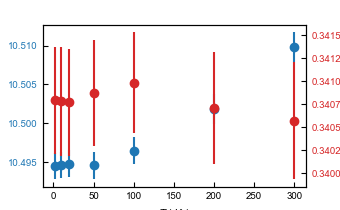

In [34]:
fig, ax = plt.subplots()

color = 'tab:blue'
ax.errorbar(Ts, results['Cell parameters'][:,0].flatten(), results['Cell parameters_err'][:,0].flatten(),fmt='o')
ax.set_ylabel('$a$ ( $\mathrm{\AA}$ )', color=color)  # we already handled the x-label with ax1
ax.set_xlabel('$T$ ( K )')
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('$x_{48f}$', color=color)  # we already handled the x-label with ax1
ax2.errorbar(Ts, results['Xo48f'].flatten(), results['Xo48f_err'].flatten(), fmt='o',c=color)# error for Xo48f /1e5 for loaded from "*.sum"
ax2.tick_params(axis='y', labelcolor=color)
fig.savefig(os.path.join(path,'lattic.pdf'), bbox_inches='tight',pad_inches=0.01)  
print(os.path.join(path,'lattic.pdf'))
plt.show()

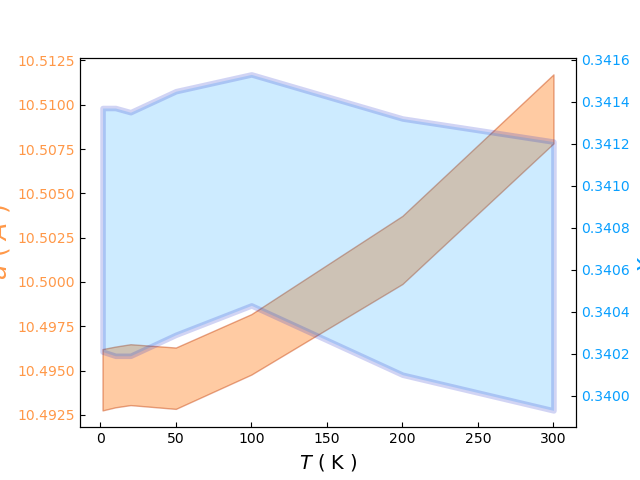

In [18]:
fig, ax = plt.subplots()

color = '#FF9848'
ax.fill_between(Ts, 
                results['Cell parameters'][:,0]+results['Cell parameters_err'][:,0],
                results['Cell parameters'][:,0]-results['Cell parameters_err'][:,0],
                alpha=0.5, edgecolor='#CC4F1B', facecolor=color)
ax.set_ylabel('$a$ ( $\AA$ )', color=color,size=18)  # we already handled the x-label with ax1
ax.set_xlabel('$T$ ( K )',fontsize=14)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = '#089FFF'
ax2.set_ylabel('$x_{O48f}$', color=color,size=18)  # we already handled the x-label with ax1
ax2.fill_between(Ts, 
                 (results['Xo48f']+results['Xo48f_err']).reshape(-1), 
                 (results['Xo48f']-results['Xo48f_err']).reshape(-1), 
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=4, antialiased=True)
ax2.tick_params(axis='y', labelcolor='#089FFF')

plt.show()

## Plot zero, cos, and sin

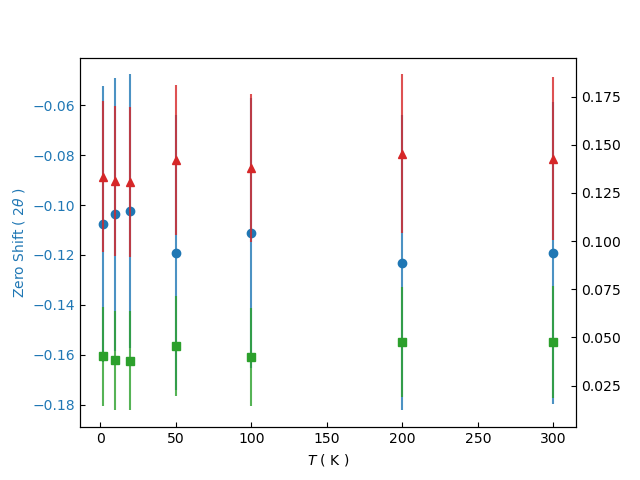

In [19]:
def multicolor_ylabel(ax,list_of_strings,list_of_colors,axis='x',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax specifies the axes object where the labels should be drawn
    list_of_strings is a list of all of the text items
    list_if_colors is a corresponding list of colors for the strings
    axis='x', 'y', or 'both' and specifies which label(s) should be drawn
    from: https://stackoverflow.com/questions/33159134/matplotlib-y-axis-label-with-multiple-colors
    """
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes,align="center",pad=0, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad,frameon=False,bbox_to_anchor=(0.2, -0.09),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='center',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1],list_of_colors) ]
        ybox = VPacker(children=boxes,align="center", pad=0, sep=0)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=(1.15, 0.2), 
                                          bbox_transform=ax.transAxes, borderpad=0.)# bbox_to_anchor: lable position
        ax.add_artist(anchored_ybox)

fig, ax = plt.subplots()

color = 'tab:blue'
markers, caps, bars = ax.errorbar(Ts, results['Zero-point'].flatten(), results['Zero-point_err'].flatten(),fmt='o')
# loop through bars and caps and set the alpha value
[bar.set_alpha(0.8) for bar in bars]

ax.set_ylabel(r'Zero Shift ( $2\theta$ )', color=color)  # we already handled the x-label with ax1
ax.set_xlabel('$T$ ( K )')
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

markers, caps, bars = ax2.errorbar(Ts, results['Sin(2theta)-shift'].flatten(), results['Sin(2theta)-shift_err'].flatten(), fmt='^',c='tab:red')
[bar.set_alpha(0.8) for bar in bars]
markers, caps, bars = ax2.errorbar(Ts, results['Cos(2theta)-shift'].flatten(), results['Cos(2theta)-shift_err'].flatten(), fmt='s',c='tab:green')
[bar.set_alpha(0.8) for bar in bars]
ax2.tick_params(axis='y', labelcolor='black')
multicolor_ylabel(ax2, (r'$\cos(\theta)$',' /', r'$sin(\theta)$'), ('tab:red','black','tab:green'), axis='y', weight='bold')
#ax2.set_ylabel(r'$\cos(\theta)/\sin(\theta)$', color='black',size=18)  # we already handled the x-label with ax1
#fig.savefig(os.path.join(path,'zeros.pdf'), bbox_inches='tight',pad_inches=0.01,verbose=True)  
plt.show()

## Plot Uequiv

In [20]:
def addBreakClips(ax1,ax2, which='y'):
    """ Code to add diagonal slashes to truncated y-axes.
    copied from http://matplotlib.org/examples/pylab_examples/broken_axis.html"""
    _, _, w1, h1 = ax1.get_position().bounds
    _, _, w2, h2 = ax2.get_position().bounds
    lw1 = ax1.spines['left'].get_linewidth()
    lw2 = ax2.spines['left'].get_linewidth()
    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    angle = np.pi/4
    if which=='y':
        d1 = d*w1/h1 * np.tan(angle) # for 45 degree axis break line
        kwargs = dict(transform=ax1.transAxes, color='black', clip_on=False, lw=lw1)
        ax1.plot((-d,+d),(-d1,+d1), **kwargs)      # top-left diagonal
        ax1.plot((1-d,1+d),(-d1,+d1), **kwargs)    # top-right diagonal

        d2 = d*w2/h2 * np.tan(angle)
        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d,+d),(1-d2,1+d2), **kwargs)   # bottom-left diagonal
        ax2.plot((1-d,1+d),(1-d2,1+d2), **kwargs) # bottom-right diagonal
    elif which=='x':
        d1 = d*w1/h1 * np.tan(angle)
        kwargs = dict(transform=ax1.transAxes, color='black', clip_on=False, lw=lw1)
        ax1.plot((1-d,1+d),(-d1,+d1), **kwargs)      # left-bottom diagonal
        ax1.plot((1-d,1+d),(1-d1,1+d1), **kwargs)    # left-top diagonal

        d2 = d*w2/h2 * np.tan(angle)
        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d,+d),(-d2,+d2), **kwargs)   # right-bottom diagonal
        ax2.plot((-d,+d),(1-d2,1+d2), **kwargs) # right-top diagonal        

In [21]:
# Calculate Uequiv error from B_av error
"""https://stackoverflow.com/questions/37149933/how-to-set-max-output-width-in-numpy
"""
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.8g" % x))

print(results['B11_err'].shape)
Uequiv_err = results['B11_err'].reshape(7,7,6)[:,:,0:3].mean(axis=2)/(2*np.pi**2) / (1/10.5/10.5)
#0.016623/(2*np.pi**2) / (1/10.5/10.5)
print(Uequiv_err)
print(results['B11_err'].reshape(7,7,6)[0,:,:])

(7, 42)
[[0.0015080392 0.0015080392 0.001826403 0.001826403 0.0026995763 0.0047922134 0.037589273]
 [0.0014912832 0.0014912832 0.0018319883 0.0018319883 0.0026995763 0.0047754574 0.03686318]
 [0.0015080392 0.0015080392 0.001826403 0.001826403 0.0026846821 0.0047977987 0.035734943]
 [0.0014801125 0.0014801125 0.0018319883 0.0018319883 0.002593455 0.00482014 0.032925522]
 [0.0014354299 0.0014354299 0.0017482084 0.0017482084 0.0024761631 0.0047028481 0.034768681]
 [0.0015694778 0.0015694778 0.0018990123 0.0018990123 0.0027461207 0.0049821146 0.036868765]
 [0.0016309164 0.0016309164 0.001893427 0.001893427 0.0028112829 0.0052669664 0.042934434]]
[[0.00027 0.00027 0.00027 0.000281 0.000281 0.000281]
 [0.00027 0.00027 0.00027 0.000281 0.000281 0.000281]
 [0.000327 0.000327 0.000327 0.00044 0.00044 0.00044]
 [0.000327 0.000327 0.000327 0.00044 0.00044 0.00044]
 [0.000654 0.000398 0.000398 0 0 0.000543]
 [0.000858 0.000858 0.000858 0 0 0]
 [0.00673 0.00673 0.00673 0 0 0]]


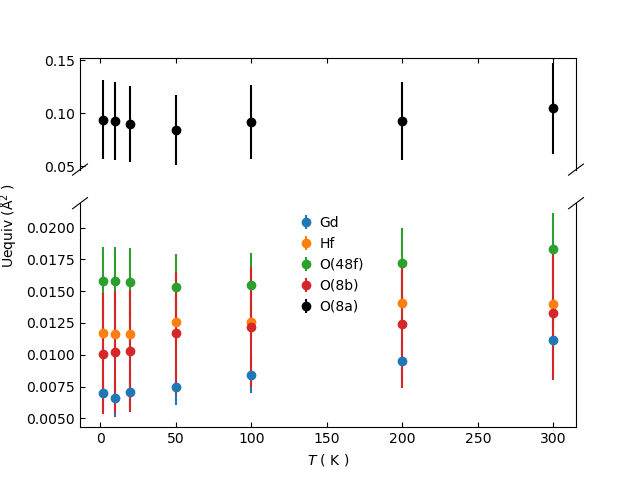

In [22]:
legs = ['Gd', 'Hf', 'O(48f)', 'O(8b)', 'O(8a)']
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True , gridspec_kw={'height_ratios': [1, 2]})

for idx, i in enumerate([0,2,4,5]):# site mixing: save B factor
    ax2.errorbar(Ts, results['Uequiv'][:,i].flatten(), Uequiv_err[:,i],fmt='o',label=legs[idx])
ax1.errorbar(Ts, results['Uequiv'][:,6], Uequiv_err[:,6],fmt='o',color='black',label=legs[4])
ax1.set_ylabel(r'Uequiv ($\mathrm{\AA}^2$ )')  # we already handled the x-label with ax1
ax1.yaxis.set_label_coords(-0.12, -0.5)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel('$T$ ( K )')
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

addBreakClips(ax1,ax2)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2+handles1, labels2+labels1,handletextpad=0,frameon=False)
#fig.savefig(os.path.join(path,'Uequiv.pdf'), bbox_inches='tight',pad_inches=0.01,verbose=True)  
plt.show()

## Plot Rwp

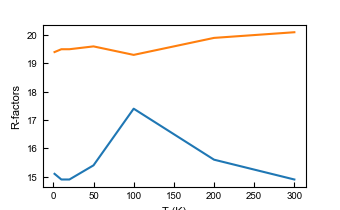

In [23]:
latexify()
plt.figure()
plt.plot(Ts, results['Rwp'][:,1],label='Rexp')
plt.plot(Ts, results['Rwp'][:,2],label='Rwp')
plt.xlabel('T (K)')
plt.ylabel('R-factors')
plt.gcf().savefig(r'D:/Downloads/test.pdf', bbox_inches='tight',pad_inches=0.01)  
plt.show()

In [24]:
np.array([0.00255,0.0055])/0.083333

array([0.030600122, 0.066000264])